# Import

In [5]:
import sys
sys.path.append('../')
sys.path.append('../../')
sys.path.append('../../../')
from mae import *
import networkx as nx
import torch
from models import VariationalAutoEncoder, DenoiseNN
from torch_geometric.data import DataLoader
from data import base_preprocess_dataset

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load graph

In [6]:
import yaml 

yaml_file = "/Users/sullivancastro/Desktop/MVA/ALTEGRAD/GGSP/run/experiment_1/config.yaml"
with open(yaml_file, "r") as file:
        yaml_data = yaml.safe_load(file)  # Parse the YAML content as a dictionary

In [7]:
autoencoder = VariationalAutoEncoder(
    yaml_data["spectral_emb_dim"] + 1,
    yaml_data["hidden_dim_encoder"],
    yaml_data["hidden_dim_decoder"],
    yaml_data["latent_dim"],
    yaml_data["n_layers_encoder"],
    yaml_data["n_layers_decoder"],
    yaml_data["n_max_nodes"],
    yaml_data["encoder_classname"],
    yaml_data["decoder_classname"],
    )
# Load the weights from /Users/sullivancastro/Desktop/MVA/ALTEGRAD/GGSP/run/experiment_1/checkpoints/best_autoencoder_checkpoint.pth.tar
autoencoder.load_state_dict(torch.load("/Users/sullivancastro/Desktop/MVA/ALTEGRAD/GGSP/run/experiment_1/checkpoints/best_autoencoder_checkpoint.pth.tar")["state_dict"])

autoencoder.encoder.eval()
autoencoder.decoder.eval()

/var/folders/pb/_7l8b_td5_jfqdxkmrdd2gf40000gn/T/ipykernel_59511/3129676263.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load("/Use

Decoder(
  (mlp): ModuleList(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=2450, bias=True)
  )
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [8]:
denoise_model = DenoiseNN(
        input_dim=yaml_data["latent_dim"],
        hidden_dim=yaml_data["hidden_dim_denoise"],
        n_layers=yaml_data["n_layers_denoise"],
        n_cond=yaml_data["n_condition"],
        d_cond=yaml_data["dim_condition"],
    )
# Load the weights from /Users/sullivancastro/Desktop/MVA/ALTEGRAD/GGSP/run/experiment_1/checkpoints/best_denoiser_checkpoint.pth.tar
denoise_model.load_state_dict(torch.load("/Users/sullivancastro/Desktop/MVA/ALTEGRAD/GGSP/run/experiment_1/checkpoints/best_denoiser_checkpoint.pth.tar")["state_dict"])

denoise_model.eval()

/var/folders/pb/_7l8b_td5_jfqdxkmrdd2gf40000gn/T/ipykernel_59511/3893916512.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  denoise_model.load_state_dict(torch.load("/Us

DenoiseNN(
  (cond_mlp): Sequential(
    (0): Linear(in_features=7, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=512, out_features=512, bias=True)
  )
  (mlp): ModuleList(
    (0): Linear(in_features=160, out_features=512, bias=True)
    (1): Linear(in_features=640, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=32, bias=True)
  )
  (bn): ModuleList(
    (0-1): 2 x BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relu): ReLU()
  (tanh): Tanh()
)

# Infer the model

In [9]:
trainset = globals()[yaml_data["dataset_preprocessing_function"]](
        "../../../data", "train", yaml_data["n_max_nodes"], yaml_data["spectral_emb_dim"]
    )

train_loader = DataLoader(
        trainset, batch_size=6, shuffle=False
    )

/Users/sullivancastro/Desktop/MVA/ALTEGRAD/GGSP/src/ggsp/metrics/../data/preprocess.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_lst = torch.load(filename)
/Use

In [29]:
data = trainset[7907]

print(f"Data: {data}")
x_g = autoencoder.encode(data)
print(f"Embeddings: {x_g}")
t = torch.randint(
            0, yaml_data["timesteps"], (x_g.size(0),)).long()
x_d = denoise_model(x_g, t, data.stats)
print(f"Reconstructed embeddings: {x_d}")
x_hat = autoencoder.decode_mu(x_d)
print(f"Reconstructed graph: {x_hat}")

Data: Data(x=[38, 11], edge_index=[2, 160], A=[1, 50, 50], stats=[1, 7], filename='graph_200')
Embeddings: tensor([[-2.2049, -0.4984,  0.3182, -0.3716, -0.6696,  2.3047,  1.3109,  0.6234,
         -0.4300,  0.5291, -0.9817, -0.2251, -0.9127,  0.3780, -0.2394, -0.2810,
          0.2005, -0.5337, -1.7170,  0.9452,  3.7079, -0.0658, -0.2701, -0.7751,
          0.7574, -0.8570,  1.2800,  1.5549, -0.4013,  0.3857, -0.7709, -0.0358]],
       grad_fn=<AddBackward0>)
Reconstructed embeddings: tensor([[-0.2481,  0.0494,  0.1843,  0.0088, -0.2178,  0.1527,  0.0631, -0.1416,
         -0.1798,  0.0895, -0.1741, -0.3543, -0.1022,  0.0246,  0.0500, -0.0642,
          0.0213, -0.0163,  0.2106, -0.2317,  0.3125,  0.0097,  0.1948,  0.2418,
         -0.1758,  0.1113,  0.1004,  0.1595,  0.0466, -0.1817, -0.2050, -0.1078]],
       grad_fn=<AddmmBackward0>)
Reconstructed graph: tensor([[[0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
       

In [30]:
data.A

tensor([[[0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 1.,  ..., 0., 0., 0.],
         [1., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [39]:
compute_features(x_hat.squeeze())

50


array([5.00000000e+01, 3.57000000e+02, 1.42800000e+01, 3.40102639e-01,
       6.37000000e+02, 1.00000000e+01, 4.00000000e+00])

In [38]:
compute_features(data.A.squeeze())

array([38.        , 80.        ,  4.21052632,  0.16753437, 17.        ,
        3.        ,  5.        ])

In [34]:
mae(x_hat, data.A)

np.float64(927.2420419567695)

This graph comprises 28 nodes and 329 edges. The average degree is equal to 23.5 and there are 2178 triangles in the graph. The global clustering coefficient and the graph's maximum k-core are 0.8763412017167382 and 20 respectively. The graph consists of 2 communities.

In [14]:
data.stats[0]

tensor([2.8000e+01, 3.2900e+02, 2.3500e+01, 2.1780e+03, 8.7634e-01, 2.0000e+01,
        2.0000e+00])

In [15]:
compute_features(data.A[0])

array([2.80000000e+01, 3.29000000e+02, 2.35000000e+01, 8.77991492e-01,
       2.17800000e+03, 2.00000000e+01, 2.00000000e+00])

In [66]:
data.__dict__['_store']['filename']

['graph_7029',
 'graph_5348',
 'graph_2289',
 'graph_1320',
 'graph_4180',
 'graph_3041']

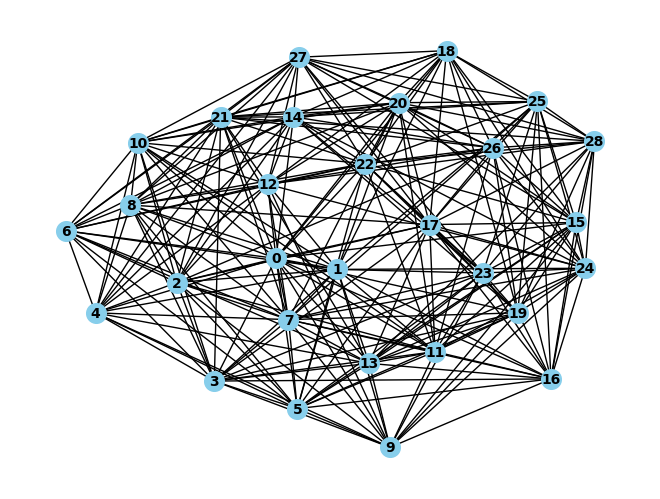

In [65]:
adj = data[0].A.squeeze()

active_nodes = (adj != 0).any(axis=1)
reduced_adj = adj[active_nodes][:, active_nodes]
G = nx.from_numpy_array(reduced_adj.numpy())
nx.draw(G, with_labels=True, font_weight='bold', node_color='skyblue', node_size=200, font_size=10)

In [61]:
for i in range(len(trainset)):
    if trainset[i].filename == "graph_838":
        print(i)
        break

7924


In [62]:
trainset[7924].stats

tensor([[10.0000, 16.0000,  3.2000,  7.0000,  0.2958,  2.0000,  2.0000]])

In [63]:
compute_features(trainset[7924].A.squeeze())

array([10.        , 16.        ,  3.2       ,  7.        ,  0.74444444,
        2.        ,  1.        ])

In [67]:
trainset[7924].A

tensor([[[0., 1., 1.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         [1., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])